<h1>Predict Student Performance</h1>

In [3]:
#Data Manipulation
import numpy as np
import pandas as pd

#Machine Learning Library
from sklearn.model_selection import GridSearchCV,KFold
from sklearn.preprocessing import OrdinalEncoder,OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score,confusion_matrix
#Visualization
import matplotlib.pyplot as plt
import seaborn as sns

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


pd.set_option("display.max_rows",100)


In [4]:
path="exams.csv"
df_student=pd.read_csv(path)
student_train=df_student[:800]
student_test=df_student[len(student_train):]

In [5]:
df_student

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group D,some college,standard,completed,59,70,78
1,male,group D,associate's degree,standard,none,96,93,87
2,female,group D,some college,free/reduced,none,57,76,77
3,male,group B,some college,free/reduced,none,70,70,63
4,female,group D,associate's degree,standard,none,83,85,86
...,...,...,...,...,...,...,...,...
995,male,group C,some college,standard,none,77,77,71
996,male,group C,some college,standard,none,80,66,66
997,female,group A,high school,standard,completed,67,86,86
998,male,group E,high school,standard,none,80,72,62


<p> This Cell is to understand how to calculate the memory usage in tables </p>

In [6]:
mem=df_student.memory_usage().sum()/1024**2
print("Memory usage is {:.2f} MB".format(mem))

Memory usage is 0.06 MB


In [7]:
# Table Information
print("The Dataset Is {} Rows Long".format(len(df_student)))
print("The Dataset Has {} Columns".format(len(df_student.columns)))
print()

# Checking For Any Missing Values
missing_values=df_student.isna().sum().sum()
if missing_values == 0:
    print("The Dataset has {} Missing Values".format(missing_values))
else:
    print("The Dataset has {} Missing Values".format(missing_values))

print("Training Data Are {} Rows Long".format(len(student_train)))
print("Testing Data Are {} Rows Long".format(len(student_test)))

The Dataset Is 1000 Rows Long
The Dataset Has 8 Columns

The Dataset has 0 Missing Values
Training Data Are 800 Rows Long
Testing Data Are 200 Rows Long


In [8]:
df_student.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   gender                       1000 non-null   object
 1   race/ethnicity               1000 non-null   object
 2   parental level of education  1000 non-null   object
 3   lunch                        1000 non-null   object
 4   test preparation course      1000 non-null   object
 5   math score                   1000 non-null   int64 
 6   reading score                1000 non-null   int64 
 7   writing score                1000 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 62.6+ KB


In [9]:
#Getting The Scores Columns
scores=df_student.select_dtypes(include="int64").columns
scores

Index(['math score', 'reading score', 'writing score'], dtype='object')

In [10]:
#Getting All Race Groups
races=df_student["race/ethnicity"].unique()
races

array(['group D', 'group B', 'group C', 'group E', 'group A'],
      dtype=object)

In [11]:
#Counting each race group
for race in races:
    print("There Are {} Races Belong to {}" \
          .format(df_student["race/ethnicity"][df_student["race/ethnicity"]==race].count(),race))

There Are 257 Races Belong to group D
There Are 198 Races Belong to group B
There Are 323 Races Belong to group C
There Are 143 Races Belong to group E
There Are 79 Races Belong to group A


In [12]:
columns=df_student.select_dtypes(include="int64").columns

In [13]:
#Highlighting scores from lowest to highest
df_student.head(10).style.format({columns[0]:"{:.2f} %",
                                 columns[1]:"{:.2f} %",
                                 columns[2]:"{:.2f} %",})\
                            .background_gradient(cmap="inferno"
                                                 ,low=1,axis=1)

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group D,some college,standard,completed,59.00 %,70.00 %,78.00 %
1,male,group D,associate's degree,standard,none,96.00 %,93.00 %,87.00 %
2,female,group D,some college,free/reduced,none,57.00 %,76.00 %,77.00 %
3,male,group B,some college,free/reduced,none,70.00 %,70.00 %,63.00 %
4,female,group D,associate's degree,standard,none,83.00 %,85.00 %,86.00 %
5,male,group C,some high school,standard,none,68.00 %,57.00 %,54.00 %
6,female,group E,associate's degree,standard,none,82.00 %,83.00 %,80.00 %
7,female,group B,some high school,standard,none,46.00 %,61.00 %,58.00 %
8,male,group C,some high school,standard,none,80.00 %,75.00 %,73.00 %
9,female,group C,bachelor's degree,standard,completed,57.00 %,69.00 %,77.00 %


In [14]:
df_student.describe()

,math score,reading score,writing score
count,1000.000000,1000.000000,1000.000000
mean,67.810000,70.382000,69.140000
std,15.250196,14.107413,15.025917
min,15.000000,25.000000,15.000000
25%,58.000000,61.000000,59.000000
50%,68.000000,70.500000,70.000000
75%,79.250000,80.000000,80.000000
max,100.000000,100.000000,100.000000


In [15]:

print("The math score median is {}".format(np.median(df_student["math score"])))
print("The reading score median is {}".format(np.median(df_student["reading score"])))
print("The writing score median is {}".format(np.median(df_student["writing score"])))

The math score median is 68.0
The reading score median is 70.5
The writing score median is 70.0


In [16]:
df_student_copy=df_student.copy()

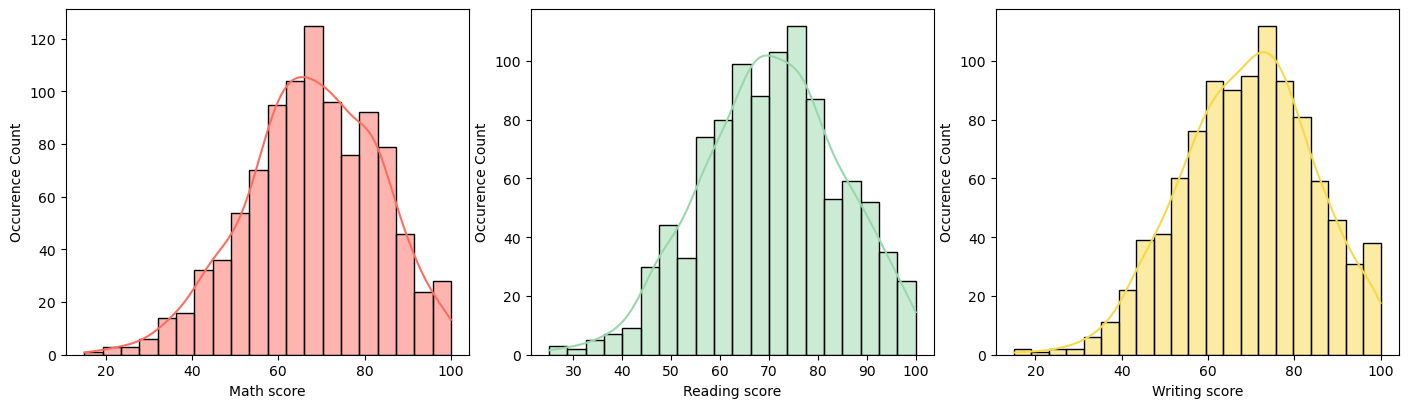

In [17]:
colors=["#FF6D60","#98D8AA","#F9D949"]
# This is gonna select only the score cols
n_cols=df_student_copy.select_dtypes(include="int64").columns

#Plot Distributions
fig,axs=plt.subplots(1,3,figsize=(14,4))
axs=axs.flat
for colm,ax,color in zip(n_cols,axs,colors):
    sns.histplot(ax=ax,data=df_student_copy,x=colm,kde=True,color=color)
    ax.set_xlabel(str(colm).capitalize())
    ax.set_ylabel("Occurence Count")


plt.tight_layout(pad=0.4)
plt.show()

In [18]:
level_education=df_student_copy["parental level of education"]

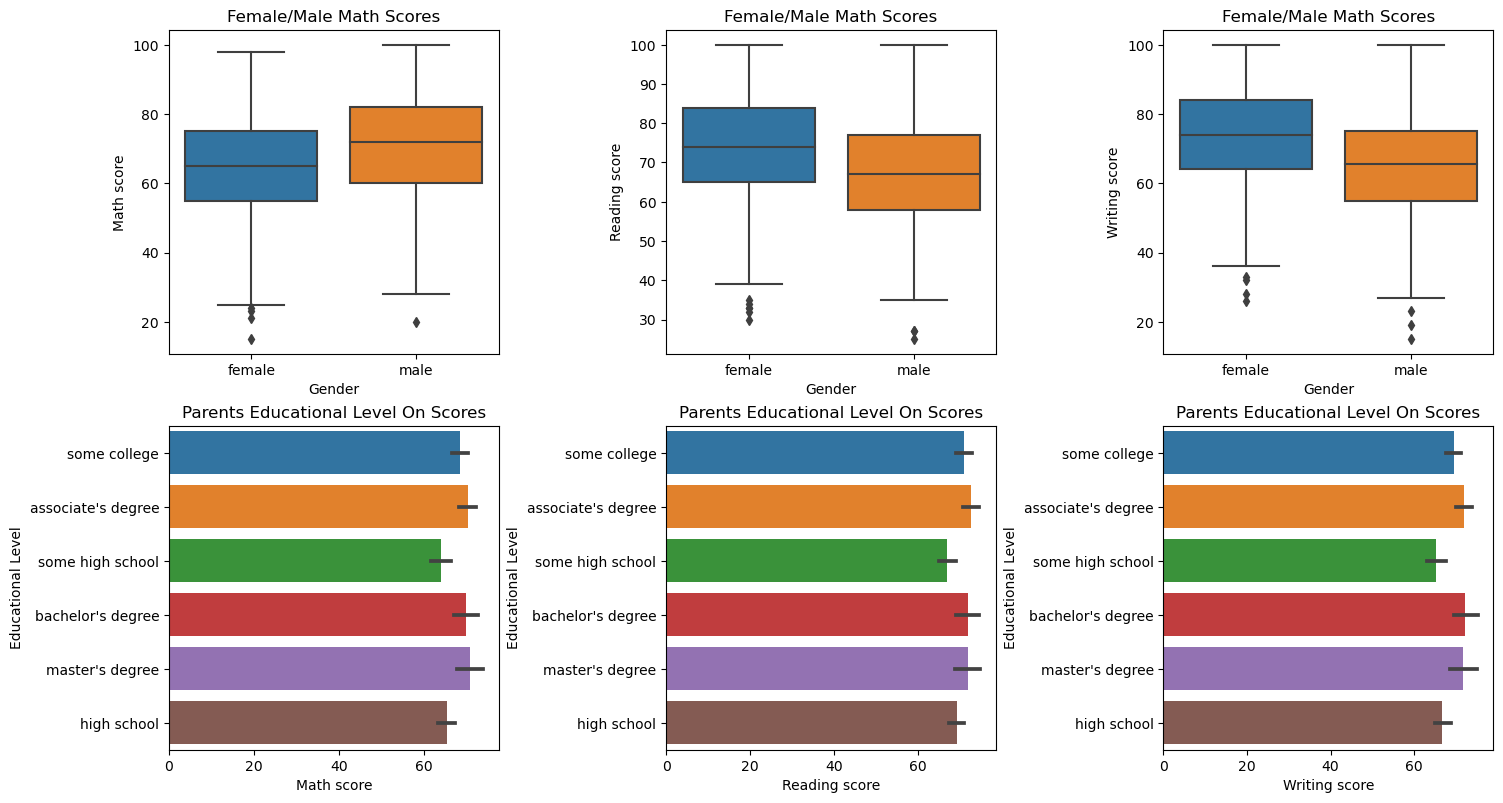

In [19]:
fig,axs=plt.subplots(2,3,figsize=(15,8))
#Plotting Female On Male Scores
sns.boxplot(ax=axs[0][0],data=df_student_copy,x="gender",y=n_cols[0])
axs[0][0].set_title("Female/Male Math Scores")
axs[0][0].set_xlabel("Gender")
axs[0][0].set_ylabel(str(n_cols[0]).capitalize())

sns.boxplot(ax=axs[0][1],data=df_student_copy,x="gender",y=n_cols[1])
axs[0][1].set_title("Female/Male Math Scores")
axs[0][1].set_xlabel("Gender")
axs[0][1].set_ylabel(str(n_cols[1]).capitalize())

sns.boxplot(ax=axs[0][2],data=df_student_copy,x="gender",y=n_cols[2])
axs[0][2].set_title("Female/Male Math Scores")
axs[0][2].set_xlabel("Gender")
axs[0][2].set_ylabel(str(n_cols[2]).capitalize())

#Parents Level Of Education On Scores
sns.barplot(ax=axs[1][0],data=df_student_copy,x=n_cols[0],y=level_education)
axs[1][0].set_title("Parents Educational Level On Scores")
axs[1][0].set_xlabel(str(n_cols[0]).capitalize())
axs[1][0].set_ylabel("Educational Level")

sns.barplot(ax=axs[1][1],data=df_student_copy,x=n_cols[1],y=level_education)
axs[1][1].set_title("Parents Educational Level On Scores")
axs[1][1].set_xlabel(str(n_cols[1]).capitalize())
axs[1][1].set_ylabel("Educational Level")

sns.barplot(ax=axs[1][2],data=df_student_copy,x=n_cols[2],y=level_education)
axs[1][2].set_title("Parents Educational Level On Scores")
axs[1][2].set_xlabel(str(n_cols[2]).capitalize())
axs[1][2].set_ylabel("Educational Level")
plt.tight_layout(pad=0.6)
plt.show()

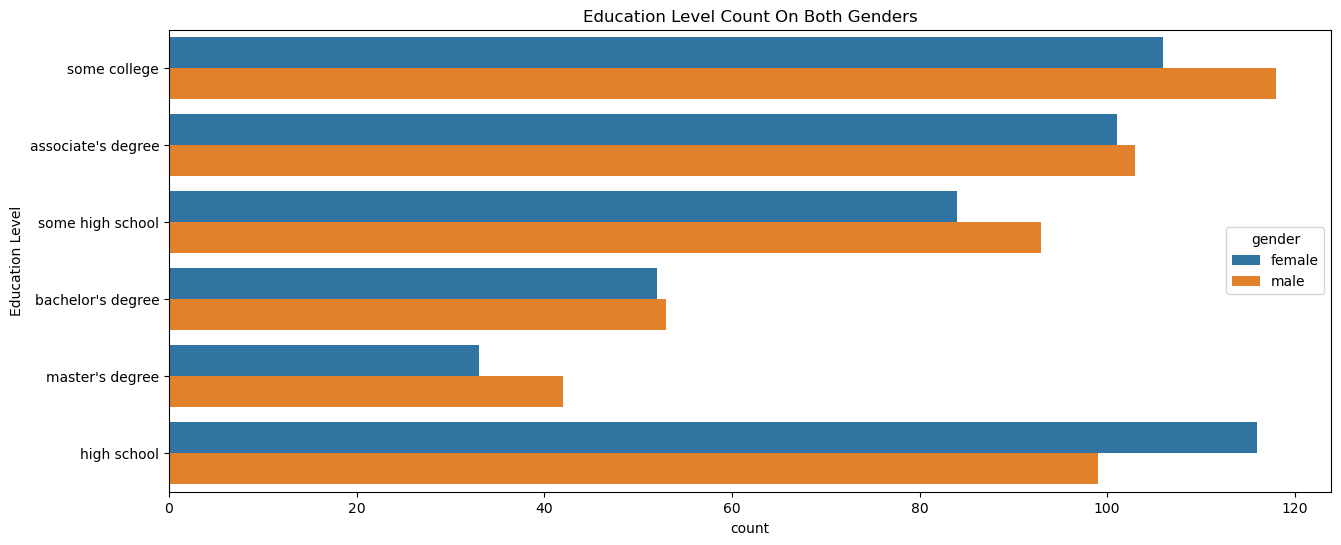

In [20]:
plt.figure(figsize=(15,6))
sns.countplot(data=df_student_copy,y=level_education,hue="gender")
plt.title("Education Level Count On Both Genders")
plt.ylabel("Education Level")
plt.show()

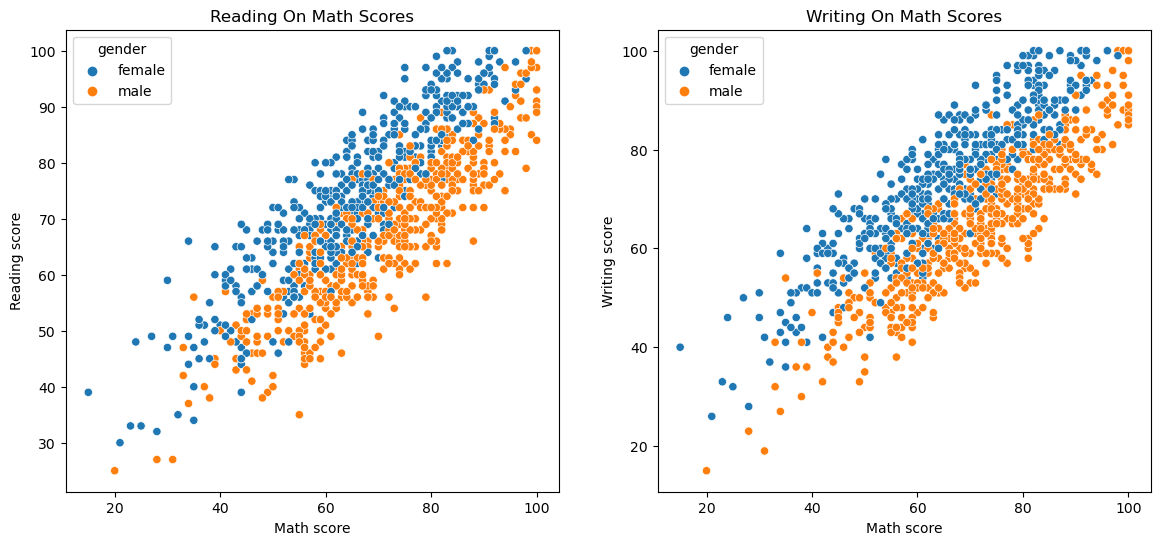

In [21]:
#Plotting Corrolation Between Scores
fig,axs=plt.subplots(1,2,figsize=(14,6))

sns.scatterplot(ax=axs[0],data=df_student_copy,x=n_cols[0],y=n_cols[1],hue="gender")
axs[0].set_title("Reading On Math Scores")
axs[0].set_xlabel(str(n_cols[0]).capitalize())
axs[0].set_ylabel(str(n_cols[1]).capitalize())

sns.scatterplot(ax=axs[1],data=df_student_copy,x=n_cols[0],y=n_cols[2],hue="gender")
axs[1].set_title("Writing On Math Scores")
axs[1].set_xlabel(str(n_cols[0]).capitalize())
axs[1].set_ylabel(str(n_cols[2]).capitalize())
plt.show()

<h3>Prediction Phase</h3>

In [22]:
# How Many Parents Educational Level Are There And What They Are
level_education_columns=level_education.unique()
print("There are {} unique values".format(len(level_education_columns)))
print("{}".format([_ for _ in level_education_columns]))

There are 6 unique values
['some college', "associate's degree", 'some high school', "bachelor's degree", "master's degree", 'high school']


In [23]:
def preprocess(df,column,dropped):
    """Preprocess Function Encode Categorical Data
        - df : Is The DataFrame
        - column : Is Column To be Encoded
        - dropped : Are Columns That Not Needed For Now """

    UNIQUE_VALUES=2
    encoders={}
    #OneHot Encoder Is For Encoding female/male Categories
    one_hot=OneHotEncoder()
    #OrdinalEncoder Is Good for encoding the educational level
    ord_enc=OrdinalEncoder()
    #Add Each Encoded Feature To Dict Then Replace Old Values With Encoded Ones
    for _,col in enumerate(column):
        if df[col].nunique()==UNIQUE_VALUES:
            encoders["encoder"+str(_)]=one_hot.fit_transform(df[[col]]).toarray()
        else:
            encoders["encoder"+str(_)]=ord_enc.fit_transform(df[[col]])
        df[col]=encoders["encoder"+str(_)]

    df.drop(columns=dropped,inplace=True)
    return df

In [24]:
columns=["gender","test preparation course","parental level of education"]
drop=["race/ethnicity","lunch"]
new_student_train=preprocess(student_train,columns,drop)

C:\Users\archita\AppData\Local\Temp\ipykernel_3288\3368953133.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col]=encoders["encoder"+str(_)]
C:\Users\archita\AppData\Local\Temp\ipykernel_3288\3368953133.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col]=encoders["encoder"+str(_)]
C:\Users\archita\AppData\Local\Temp\ipykernel_3288\3368953133.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

In [25]:
new_student_train=new_student_train[["gender","parental level of education",
                                     "test preparation course","reading score",
                                    "writing score","math score"]]

In [26]:
new_student_train.head()

,gender,parental level of education,test preparation course,reading score,writing score,math score
0,1.0,4.0,1.0,70,78,59
1,0.0,0.0,0.0,93,87,96
2,1.0,4.0,0.0,76,77,57
3,0.0,4.0,0.0,70,63,70
4,1.0,0.0,0.0,85,86,83


In [27]:
X=new_student_train.iloc[:,:-1].values
y=new_student_train.iloc[:,-1].values

In [28]:
%%time
kf=KFold(n_splits=5,shuffle=True)
pred_scores=[]
for i,(train_index,val_index) in enumerate(kf.split(X,y)):
    X_train,X_val=X[train_index],X[val_index]
    y_train,y_val=y[train_index],y[val_index]
    dtr=DecisionTreeRegressor(random_state=0)
    dtr.fit(X_train,y_train)
    score=r2_score(y_val,dtr.predict(X_val))
    pred_scores.append(score)

CPU times: total: 0 ns
Wall time: 15.4 ms


In [29]:
print("The Mean Prediction Is {}".format(np.mean(pred_scores)))

The Mean Prediction Is 0.6533709902251209
